## Import Required Libraries

In [1]:
# common libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
import sklearn
import warnings
warnings.filterwarnings('ignore')

# machine learning libraries    

# preprocessing libraries, split data, gid search configuration, cross validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
# linear classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier   
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import make_scorer

import pydotplus    
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import itertools

## Load Data

In [2]:
# read csv file
#top_20 = pd.read_csv('../data/top_20_features.csv')
data = pd.read_csv('../data/59_features.csv')

print('Shape of dataframe prior to modeling:', data.shape)
display(data)

Shape of dataframe prior to modeling: (1269, 59)


,test_oxycodone_0,test_cocaine_0,test_methamphetamine_0,test_opiate300_0,test_oxycodone_1,test_cocaine_1,test_methamphetamine_1,test_opiate300_1,test_oxycodone_2,test_cocaine_2,...,mdh_gi_problems,mdh_thyroid_problems,mdh_heart_condition,mdh_asthma,mdh_hypertension,mdh_skin_disease,mdh_head_injury,mdh_opi_withdrawal,mdh_epilepsy,dropout
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,yes_history,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,no_history,no_history,no_history,no_history,no_history,yes_history,no_history,no_history,no_history,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,no_history,no_history,no_history,no_history,no_history,yes_history,no_history,yes_history,no_history,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,no_history,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history,0.0
4,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,yes_history,no_history,no_history,no_history,yes_history,no_history,no_history,yes_history,no_history,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,no_history,no_history,no_history,yes_history,no_history,no_history,yes_history,no_history,no_history,1.0
1265,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,1.0
1266,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,no_history,no_history,no_history,yes_history,yes_history,no_history,no_history,yes_history,no_history,1.0
1267,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,no_history,no_history,no_history,no_history,yes_history,yes_history,no_history,yes_history,no_history,1.0


## Split the Data to Dev and Test sets

In [3]:

# assign variables
X, y = data.drop(columns='dropout'), data['dropout']

# create the dev and test sets 
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.14, random_state=42)

# create the train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.16, random_state=42)

# check the shape of the train, validation, and test sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)



Shape of X_train: (916, 58)
Shape of X_val: (175, 58)
Shape of X_test: (178, 58)


## Review Patient Profile

In [4]:

X_train.iloc[215, :]

test_oxycodone_0                         0.0
test_cocaine_0                           0.0
test_methamphetamine_0                   0.0
test_opiate300_0                         1.0
test_oxycodone_1                         0.0
test_cocaine_1                           0.0
test_methamphetamine_1                   0.0
test_opiate300_1                         0.0
test_oxycodone_2                         0.0
test_cocaine_2                           0.0
test_methamphetamine_2                   0.0
test_opiate300_2                         0.0
test_oxycodone_3                         0.0
test_cocaine_3                           0.0
test_methamphetamine_3                   0.0
test_opiate300_3                         0.0
test_oxycodone_4                         0.0
test_cocaine_4                           0.0
test_methamphetamine_4                   0.0
test_opiate300_4                         0.0
survey_cannabis_0                        0.0
survey_cocaine_0                         0.0
survey_oxy

## Create Pipeline Function

In [5]:
# Import column transformer, standard scaler, one hot encoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def preprocess_data(train_df, val_df, test_df, numeric_features, categorical_features):
    # Define the column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )
    
    # Fit the preprocessor on the training data
    preprocessor.fit(train_df)
    
    # Transform the training, validation, and test data
    X_train = preprocessor.transform(train_df)
    X_val = preprocessor.transform(val_df)
    X_test = preprocessor.transform(test_df)
    
    return X_train, X_val, X_test, preprocessor

In [6]:
# numeric features
numeric_features = [col for col in X_train.columns if X_train[col].dtype != 'object']
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'object']

# preprocess the data
X_train, X_val, X_test, pipeline = preprocess_data(X_train, X_val, X_test, numeric_features, categorical_features)


## Use Grid Search
We will create a reusable function to perform grid search with any classifier

In [7]:
# create custom grid search function
def perform_grid_search(X_train, y_train, X_val, y_val, classifier, hyperparams):
    """
    Perform grid search with cross-validation for a given classifier and hyperparameters.

    Parameters:
    - X_train: Training features dataframe.
    - y_train: Training target series.
    - X_val: Validation features dataframe.
    - y_val: Validation target series.
    - classifier: The classifier to use (e.g., XGBClassifier()).
    - hyperparams: Dictionary of hyperparameters to search.

    Returns:
    - results_df: Pandas DataFrame containing the results of the grid search.
    """
    # Define a custom scoring function for the C-index
    def cindex_score(y_true, y_pred):
        return helper.cindex(y_true, y_pred)

    # Wrap the custom scoring function using make_scorer
    cindex_scorer = make_scorer(cindex_score, greater_is_better=True)

    # Set up GridSearchCV with cross-validation and custom scorer
    grid_search = GridSearchCV(estimator=classifier, param_grid=hyperparams, cv=5, scoring=cindex_scorer, n_jobs=-1, verbose=1)

    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)

    # Retrieve the best parameters
    best_params = grid_search.best_params_
    
    # Retrieve the best model
    best_model = grid_search.best_estimator_

    # Get the probability scores from the best model
    y_val_preds = best_model.predict_proba(X_val)[:, 1]

    # Calculate the C-index on the validation set
    c_index = helper.cindex(y_val.values, y_val_preds)
    
    # Store the results in a DataFrame
    results = pd.DataFrame(grid_search.cv_results_)

    return results


## Define Param Grid and loop through pipelines

In [8]:
# Define the classifiers and hyperparameters

classifiers = {
    'Logistic Regression': (LogisticRegression(), {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4],
        'min_samples_split': [2, 5, 10]
    }),
    'XGBoost': (XGBClassifier(), {
        'learning_rate': [0.001, 0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5]
    })
}

# store results in a dictionary
results = {}

# Perform grid search for each classifier
for clf_name, (clf, params) in classifiers.items():
    print(f"Running grid search for {clf_name}...")
    results[clf_name] = perform_grid_search(X_train, y_train, X_val, y_val, clf, params)
    print()


# print the best results for each classifier
for clf_name, _ in classifiers.items():
    best_cindex = results[clf_name]['mean_test_score'].max()
    best_params = results[clf_name]['params'][results[clf_name]['mean_test_score'].idxmax()]
    print(f"Best C-index for {clf_name}: {best_cindex:.4f}")
    print(f"Best hyperparameters: {best_params}")
    print()

Running grid search for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Running grid search for Random Forest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Running grid search for XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best C-index for Logistic Regression: 0.7212
Best hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Best C-index for Random Forest: 0.7202
Best hyperparameters: {'max_depth': 4, 'min_samples_split': 5, 'n_estimators': 300}

Best C-index for XGBoost: 0.7126
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}



## Run each classifier with the best params on the test set

In [9]:
# run each classifier with the best params on the test set
for clf_name, (clf, params) in classifiers.items():
    # Initialize the classifier
    clf.set_params(**results[clf_name].loc[results[clf_name]['rank_test_score'] == 1, 'params'].iloc[0])

    # Fit the model
    clf.fit(X_train, y_train)

    # Get the probability scores
    y_test_preds = clf.predict_proba(X_test)[:, 1]

    # Calculate the C-index
    c_index = helper.cindex(y_test.values, y_test_preds)
    print(f"{clf_name} C-index for Test Set: {c_index:.2f}")
    print()

Logistic Regression C-index for Test Set: 0.79

Random Forest C-index for Test Set: 0.76

XGBoost C-index for Test Set: 0.77



## Plot Confusion Matrix with Precision Score

Logistic Regression Precision Score: 0.62
Logistic Regression Recall Score: 0.82

Random Forest Precision Score: 0.60
Random Forest Recall Score: 0.87

XGBoost Precision Score: 0.62
XGBoost Recall Score: 0.79



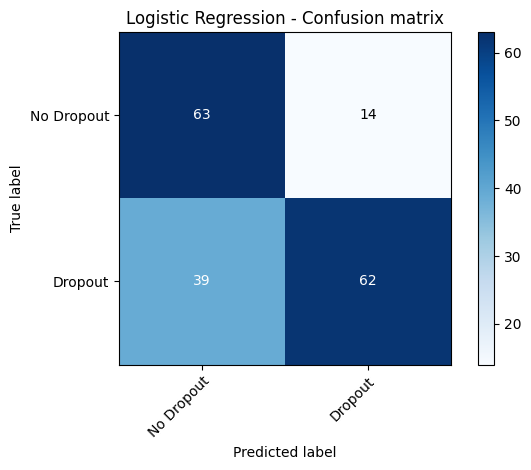

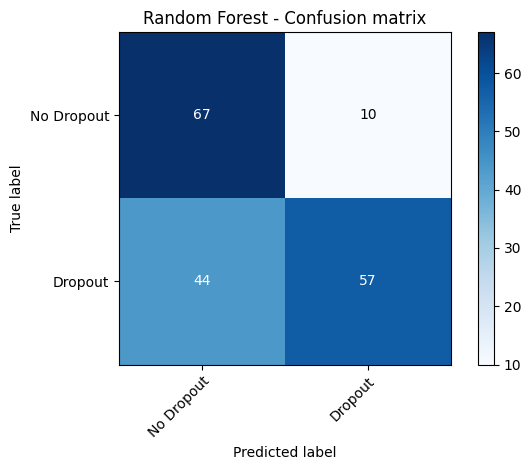

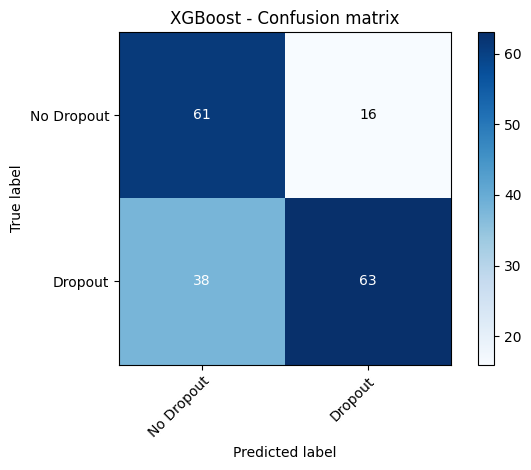

In [10]:
from sklearn.metrics import precision_score, recall_score

# Assuming y_test contains the true labels and y_test_preds contains the predicted labels
for clf_name, (clf, params) in classifiers.items():
    # Initialize the classifier
    clf.set_params(**results[clf_name].loc[results[clf_name]['rank_test_score'] == 1, 'params'].iloc[0])

    # Fit the model
    clf.fit(X_train, y_train)

    # Get the predicted labels
    y_test_preds = clf.predict(X_test)

    # calculate recall
    recall = recall_score(y_test, y_test_preds, pos_label=0.0)  # Adjust pos_label as needed

    # Calculate precision
    precision = precision_score(y_test, y_test_preds, pos_label=0.0)  # Adjust pos_label as needed
    
    # Plot the precision right before each confusion matrix
    print(f'{clf_name} Precision Score: {precision:.2f}')
    print(f'{clf_name} Recall Score: {recall:.2f}')
    print()

    # plot confusion matrix
    helper.plot_confusion_matrix(y_test, y_test_preds, classes=['No Dropout', 'Dropout'],
                          title=f'{clf_name} - Confusion matrix')

## Plot Feature Importance

In [11]:
# create classifier object
xgb = (
        classifiers['XGBoost'][0]
        .set_params(**results['XGBoost']
        .loc[results['XGBoost']['rank_test_score'] == 1, 'params']
        .iloc[0])
        )


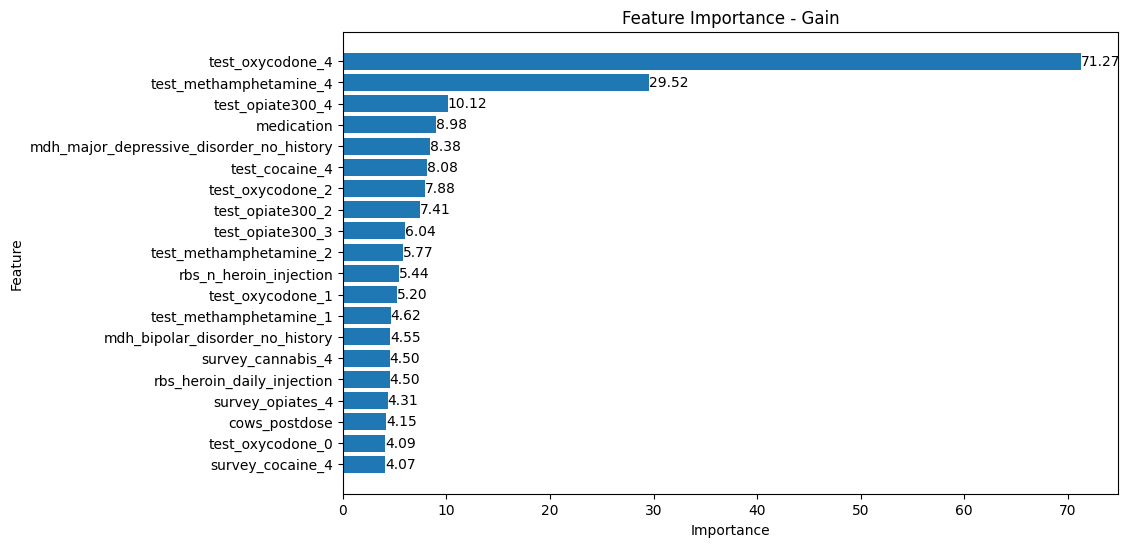

In [12]:
importance_df = helper.plot_feature_importance(xgb, pipeline, X_train, metric="gain", num_features=20)

In [ ]:
top_20 = importance_df.Feature.tolist()

# save top_20 to csv
top_20_df = pd.DataFrame(top_20, columns=['Feature'])

top_20_df.to_csv('../data/top_20_features.csv', index=False)

## Plot Decision Boundaries

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Assuming 'data' is a DataFrame and 'dropout' is the target variable
X = data[['survey_opiates_0', 'cows_postdose']]
y = data['dropout']

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X, y)

In [ ]:
import numpy as np

# Define the range for the grid
x_min, x_max = X['survey_opiates_0'].min() - 1, X['survey_opiates_0'].max() + 1
y_min, y_max = X['cows_postdose'].min() - 1, X['cows_postdose'].max() + 1

# Create a mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

In [ ]:
# Flatten the grid to pass it to the model
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the class for each point in the grid
Z = model.predict(grid)
Z = Z.reshape(xx.shape)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='survey_opiates_0', y='cows_postdose', hue='dropout', data=data)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Plot the decision boundary line
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')

plt.title('Self Reported Use Week 4, Previous 30 days heroine use')
plt.xlabel('survey_opiates_4')
plt.ylabel('rbs_heroine')
plt.legend()
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Assuming 'data' is a DataFrame and 'dropout' is the target variable
X = data[['survey_opiates_0', 'cows_postdose']]
y = data['dropout']

# Create a pipeline with standard scaling and XGBoost
model = make_pipeline(StandardScaler(), xgb.XGBClassifier())
model.fit(X, y)

In [ ]:
import numpy as np

# Define the range for the grid
x_min, x_max = X['survey_opiates_0'].min() - 1, X['survey_opiates_0'].max() + 1
y_min, y_max = X['cows_postdose'].min() - 1, X['cows_postdose'].max() + 1

# Create a mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

In [ ]:
# Flatten the grid to pass it to the model
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the class for each point in the grid
Z = model.predict(grid)
Z = Z.reshape(xx.shape)

In [ ]:
# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='survey_opiates_0', y='cows_postdose', hue='dropout', data=data)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

# Plot the decision boundary line
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')

plt.title('Withdrawal syndrome scale, medication dose and dropout')
plt.xlabel('meds_methadone_0')
plt.ylabel('cows_postdose')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the accuracies stored in the following dictionaries
accuracies = {
    'Logistic Regression': {
        'train': 0.85,
        'val': 0.80,
        'test': 0.78
    },
    'Random Forest': {
        'train': 0.90,
        'val': 0.82,
        'test': 0.80
    },
    'XGBoost': {
        'train': 0.88,
        'val': 0.83,
        'test': 0.81
    }
}

# Extract the data
models = list(accuracies.keys())
train_accuracies = [accuracies[model]['train'] for model in models]
val_accuracies = [accuracies[model]['val'] for model in models]
test_accuracies = [accuracies[model]['test'] for model in models]

# Set up the bar plot
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - width, train_accuracies, width, label='Train')
rects2 = ax.bar(x, val_accuracies, width, label='Validation')
rects3 = ax.bar(x + width, test_accuracies, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by model and dataset')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
# put legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Attach a text label above each bar in rects, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()